# Topic modeling of abilities texts
In this file I'm trying to cluster the abilities by performing topic modeling (with NMF decomposition) on their descriptions.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.stem.snowball import EnglishStemmer

from atod import Abilities, Heroes

In [2]:
# create stop-words list
heroes = Heroes.all()
heroes_names = [h.name for h in heroes]
# names of heroes commonly occur in descriptions, so
# deleting them is a good idea
words_in_heroes_names = [word.lower() for name in heroes_names for word in name.split(' ')]

eng_stop_words = TfidfVectorizer(stop_words='english').get_stop_words()
stop_words = set(words_in_heroes_names + list(eng_stop_words) 
                 + ['font', 'color', '7998b5', 'target', 'enemy', 'friendly', 'allied'])

No abilities for this HeroID == 16


In [3]:
# get all texts for all abilities
texts = Abilities.all().get_texts()
# get abilities names and  descriptions
descriptions = texts[['description', 'name']]
corpus = [a.replace('\\n', ' ').replace('%%', '%') for a in descriptions['description']]
corpus.extend(['stun', 'silence', 'short distance teleportation', 
               'prevents casting spells', 'invisibility', 'area',
               'critical damage'])

stemmer = EnglishStemmer()
stemmed_corpus = []
for doc in corpus:
    stemmed_corpus.append(' '.join([stemmer.stem(word) for word in doc.split(' ')]))

corpus = stemmed_corpus

In [4]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,  
                                   stop_words=stop_words,
                                   ngram_range=(1,3))
tfidf_vectorizer.fit(corpus)
tf_corpus = tfidf_vectorizer.transform(corpus)
tf_features_names = tfidf_vectorizer.get_feature_names()

tf_corpus.shape

(495, 1584)

In [5]:
nmf = NMF(n_components=40, init='nndsvd').fit(tf_corpus)

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic %d:" % (topic_idx))
    print(", ".join([tf_features_names[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

Topic 0:
unit, enemi unit, enemi, nearbi enemi unit, send, radius, beast, nearbi enemi, damag, swarm
Topic 1:
scepter, upgrad aghanim, aghanim, aghanim scepter, upgrad, upgrad aghanim scepter, damage upgrad aghanim, damage upgrad, summon, end
Topic 2:
movement speed, movement, speed, increas movement, increas movement speed, increas, slow movement, slow movement speed, movement speed attack, speed attack
Topic 3:
units, enemi units, nearbi enemi, nearbi enemi units, nearbi, enemi, damag nearbi enemi, damag nearbi, burn, damag
Topic 4:
dispel, type, dispel type, dispel type basic, basic dispel, type basic dispel, type basic, basic, dispel type strong, strong
Topic 5:
bonus, bonus damag, deal bonus, deal bonus damag, attack, damag, deal, chanc, grant, doubl
Topic 6:
level, base level, base, invok, level quas, base level quas, quas, base level cabe68, level cabe68, level cabe68 exort
Topic 7:
friend, friend unit, heal, heal friend unit, heal friend, unit, friend unit damag, unit heal, uni

In [6]:
# find the ability with `index` in descriptions DataFrame
# and define categories of this ability
index = 19
test = tfidf_vectorizer.transform([descriptions['description'][index]])
weights = nmf.transform(test)
topics = weights.argsort()[0][-3:]

print(descriptions['name'][index])
print(descriptions['description'][index])
print('-' * len(descriptions['name'][index]))

for topic in topics:
    for i in nmf.components_[topic].argsort()[-3:]:
        print(tf_features_names[i], end=', ')
        
    print()

fissure
Slams the ground with a mighty totem, creating an impassable ridge of stone while stunning and damaging enemy units along its line.
-------
ground, damag stun, stun, 
nearbi enemi, enemi units, units, 
stone remnant, stone, remnant, 


## Conclusion
NMF is able to define categories of abilities pretty well by taking the most important words in 3 the most valuable topics of the ability description.

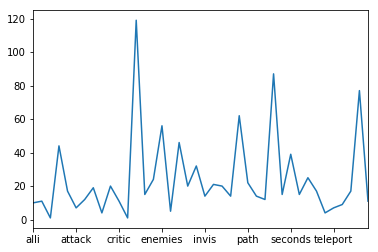

In [7]:
# distribution of categories
%matplotlib inline
categories_dist = dict()
skills_by_category = dict()

for index, text in enumerate(descriptions['description']):
    vect = tfidf_vectorizer.transform([text])
    weights = nmf.transform(vect)
    topics = weights.argsort()[0][-3:]
    
    for topic in topics:
        # find words describing topic
        for i in nmf.components_[topic].argsort()[-1:]:
            skills_by_category.setdefault(tf_features_names[i], [])
            skills_by_category[tf_features_names[i]].append(descriptions['name'][index])
            
# categories_dist = categories_dist.dropna()
categories_dist = pd.Series({k: len(skills_by_category[k]) for k in skills_by_category})
categories_dist.plot()

In [8]:
print('NOTE: the name of category can be misleading, check the above example with fissure')
print('#categories', categories_dist.shape[0])
print(categories_dist)

#categories 40
alli               10
allow              11
ani                 1
area               44
armor              17
attack              7
bonus              12
caus               19
creat               4
creep              20
critic             11
damag enemi         1
damage            119
deal damag         15
dispel             24
enemies            56
friend              5
gain               46
health             20
hero               32
invis              14
level              21
mana               20
morphl             14
movement speed     62
path               22
rang               14
remnant            12
scepter            87
second             15
seconds            39
slow               15
spell              25
spells             17
stun                4
teleport            7
tree                9
unit               17
units              77
ward               11
dtype: int64


In [9]:
# print abilities by category
print(skills_by_category['stun'])

['slithereen_crush', 'bash', 'shackleshot', 'unstable_concoction']
